# Corona prepping using Finnish data regression using a categorical boosting forest algorithm

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import glob, os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

import shap
shap.initjs()

In [2]:
# import sys
# from importlib import reload
# reload(sys)
# sys.setdefaultencoding('iso-8859-1')

In [3]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [4]:
session_info.show(req_file_name="corona_preppers_CIBER_shap_plots-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [5]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [6]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [7]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [8]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [9]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [10]:
target = "intention_behavior_composite"

In [11]:
df[target] = (df[target] - 10) * -1

In [12]:
# drop_list = [target, 'intention_store_recoded', 'intention_public_transport_recoded',
#        'intention_indoor_meeting_recoded', 'intention_restaurant_recoded',
#        'intention_pa_recoded', 'intention_composite',
#        'behaviour_indoors_nonhouseholders_recoded',
#        'behaviour_unmasked_recoded', 'behavior_composite',
#        'behavior_composite_recoded', "id", "sampling_weight",
             
#              'behaviour_indoors_nonhouseholders', 'behaviour_close_contact',
#        'behaviour_quarantined', 'behaviour_unmasked',
             
#              'intention_behavior_composite',
#        'intention_indoor_meeting', 'intention_pa',
#        'intention_public_transport', 'intention_restaurant', 'intention_store',
#             ]

# Consider only numerical features
# features_list = df.drop(drop_list, axis=1).columns.tolist()

In [13]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

## EDA on the target
Check the amount of samples in the target

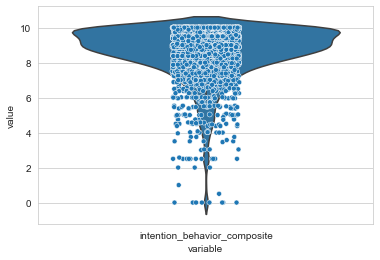

In [14]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [15]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [16]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,8.582428,1.524704,-0.0,8.017857,8.964286,9.5,10.0


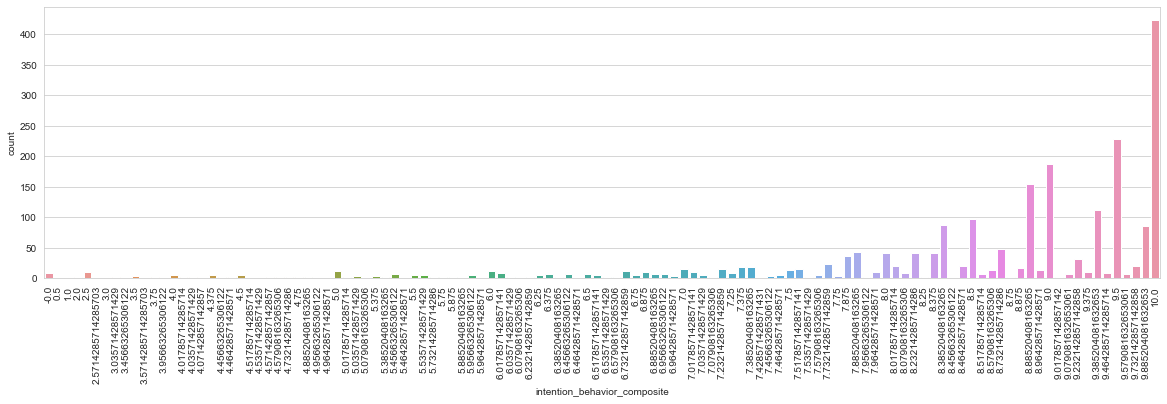

In [17]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

## Force all feature variables to categorical data

In [18]:
df[features_list] = df[features_list].astype("category")

In [19]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]]
#  .drop(drop_list, axis=1)
#  .assign(target = target_df)
#       .dropna(axis=0)
)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   object  
 1   demographic_higher_education      2272 non-null   int64   
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

In [21]:
grouping_var = target

In [22]:
display(df[grouping_var].value_counts().head().to_frame()), df.shape[0], df[grouping_var].value_counts().head().sum()

,intention_behavior_composite
10.000000,424
9.500000,228
9.000000,187
8.885204,155
9.385204,112


(None, 2272, 1106)

In [23]:
ciber_files = glob.glob("figure_data/CIBER*.csv")
# ciber_dfs = [pd.read_csv(x, encoding_errors="replace").assign(subset_name = x.split("-data-")[1].split(".")[0]) for x in ciber_files]
ciber_dfs = [pd.read_csv(x).assign(subset_name = x.split("-data-")[1].split(".")[0]) for x in ciber_files]
ciber_df = pd.concat(ciber_dfs)

In [24]:
determinant_files = glob.glob("figure_data/determinant*.csv")
# determinant_dfs = [pd.read_csv(x, encoding_errors="replace").assign(subset_name = x.split("-table-")[1].split(".")[0]) for x in determinant_files]
determinant_dfs = [pd.read_csv(x).assign(subset_name = x.split("-table-")[1].split(".")[0]) for x in determinant_files]
determinant_df = pd.concat(determinant_dfs)

In [25]:
shap_files = [x for x in glob.glob("figure_data/*.csv") if "shap" in x]

shap_dfs = [(pd.read_csv(x)
                    .assign(subset_name = x.split("/")[1].split("_shap")[0])
                    .drop("Unnamed: 0", axis=1)
                   ) for x in shap_files]
shap_df = pd.concat(shap_dfs)

## Show agreement number in the shapley values

In [26]:
shap_commonalities = (shap_df
 .groupby(["subset_name", "variable"])
 .var()
 .reset_index()
 .sort_values(["subset_name", "shap_value"])
 .groupby(["subset_name"])
 .tail(5)
 ["variable"]
 .value_counts()
)
shap_commonalities

norms_people_present_indoors        6
automaticity_put_on_mask            3
automaticity_carry_mask             3
risk_severity                       3
inst_attitude_no_needless_waste     3
risk_fear_restrictions              2
aff_attitude_safe                   2
norms_family_friends                1
inst_attitude_protects_others       1
risk_fear_spread                    1
effective_means_masks               1
aff_attitude_responsible            1
effective_means_ventilation         1
inst_attitude_sense_of_community    1
risk_fear_contagion_self            1
Name: variable, dtype: int64

#### Key (label: actual question)

In [27]:
shap_commonalities.index

Index(['norms_people_present_indoors', 'automaticity_put_on_mask',
       'automaticity_carry_mask', 'risk_severity',
       'inst_attitude_no_needless_waste', 'risk_fear_restrictions',
       'aff_attitude_safe', 'norms_family_friends',
       'inst_attitude_protects_others', 'risk_fear_spread',
       'effective_means_masks', 'aff_attitude_responsible',
       'effective_means_ventilation', 'inst_attitude_sense_of_community',
       'risk_fear_contagion_self'],
      dtype='object')

In [28]:
# dict(zip(ciber_df
#          .loc[ciber_df["label"].isin(shap_commonalities.index.tolist()), "label"]
#          .drop_duplicates()
#          .tolist(), 
#          ciber_df
#          .loc[ciber_df["label"].isin(shap_commonalities.index.tolist()), "fullLabel"]
#          .drop_duplicates()
#          .tolist()
#         )
#     )

In [50]:
(ciber_df
#          .loc[ciber_df["label"].isin(shap_commonalities.index.tolist()), ["label", "fullLabel"]]
         .drop_duplicates()
 .set_index("label")
 .to_dict()
 ["fullLabel"]
)

{'risk_fear_restrictions': "Spread of coronavirus� [ Doesn't scare\nme | Scares me ]",
 'aff_attitude_difficult_breathing': 'When I use a face mask, I feel or would\nfeel ... [ Very easy to breathe | Very\ndifficult to breathe ]',
 'risk_likely_contagion': "Perceived risk coronavirus infection [\nDoesn't scare me | Scares me ]",
 'effective_means_handwashing': 'Hand washing and use of gloves [\nIneffective | Effective ]',
 'effective_means_ventilation': 'Ventilation [ Ineffective | Effective ]',
 'risk_contagion_absent_protection': "Perceived risk coronavirus infection\nwith no protective behaviours [ Doesn't\nscare me | Scares me ]",
 'inst_attitude_enough_oxygen': "If or when I use a face mask� [ I get\nenough oxygen | I don't get enough\noxygen ]",
 'norms_officials': 'The authorities think I should .. [ Not\nto use a mask | Use a mask ]',
 'inst_attitude_sense_of_community': 'If or when I use a face mask� [ It\ndecreases sense of community | It\nincreases sense of community ]',
 'a

In [30]:
relabel_dict = dict(zip(['Younger than 40', '40 to 59', '60 or older', 'fullSample', 'Theoretical', 'Practical'], shap_df["subset_name"].sort_values().unique().tolist()))

In [31]:
_ = ciber_df.replace(relabel_dict, inplace = True)
_ = determinant_df.replace(relabel_dict, inplace = True)

In [32]:
# determinant_df = (ciber_df[["label", "fullLabel"]]
#                   .merge(determinant_df, 
#                          left_on="fullLabel", 
#                          right_on="determinant", 
#                          how="inner")
#                   .drop("determinant", axis=1)
#                  )

In [33]:
label_name = "label" # can be label or fullLabel

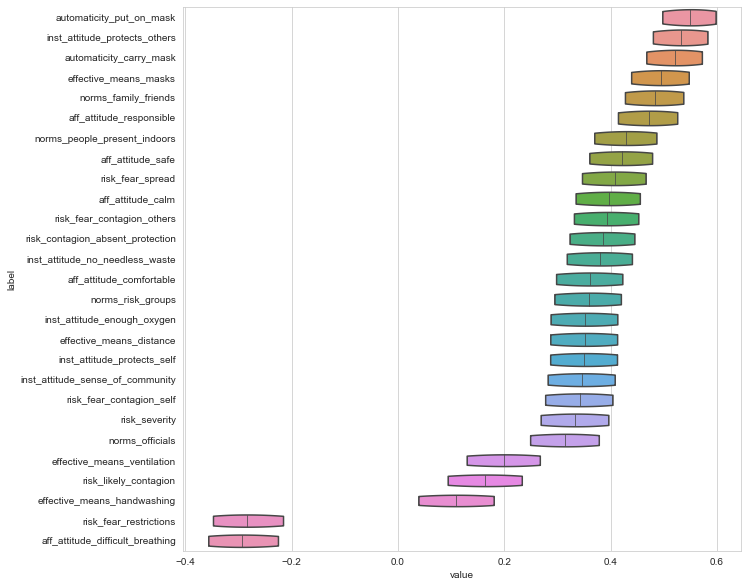

In [34]:
ciber_tmp_df = ciber_df[ciber_df["subset_name"] == "18 - 39"]
var_order = ciber_tmp_df.sort_values(by = "r_point", ascending = False)[label_name].tolist()

plot_df = ciber_tmp_df[["r_ci_lo", "r_point", "r_ci_hi", label_name]].melt(id_vars=label_name)

_ = plt.figure(figsize=(10, 10))
_ = sns.violinplot(data=plot_df, 
                x="value", 
                y=label_name,
#                 hue="actual_value",
              order=var_order,
                   inner="stick",
                   cut=0
#                 ax=axs[i],
#                     palette="rocket"
                )

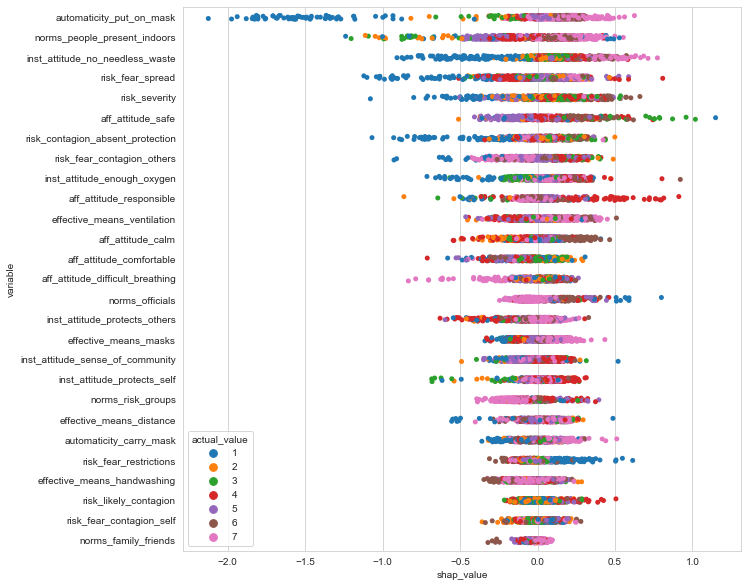

In [35]:
tmp_shap_df = shap_df[shap_df["subset_name"] == "18 - 39"]
var_order = tmp_shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()

_ = plt.figure(figsize=(10, 10))
_ = sns.stripplot(data=tmp_shap_df, 
                x="shap_value", 
                y="variable",
                hue="actual_value",
              order=var_order,
#                 ax=axs[i],
#                     palette="rocket"
                )

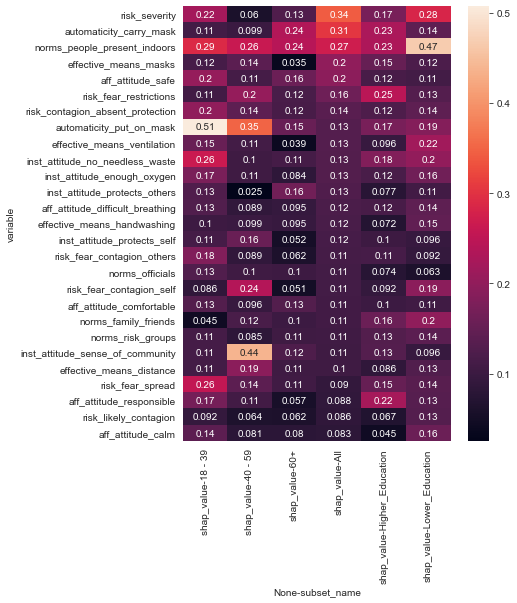

In [48]:
_ = plt.figure(figsize=(6, 8))
_ = sns.heatmap(data=shap_df
                 .groupby(["subset_name", "variable"])
                 .std()
                 .loc[:, ["shap_value"]]
                 .reset_index()
                 .pivot(index="variable", columns="subset_name")
                .sort_values(by=("shap_value", "All"), ascending=False)
                ,
               annot=True,   
)

In [36]:
stop!

SyntaxError: invalid syntax (<ipython-input-36-8c726f94684c>, line 1)

In [49]:
determinant_df.head(3)

,determinant,lower,current,upper,weight,p_delta,subset_name
0,"When I use a face mask, I feel or would\nfeel ...",0,0.438272,1.0,0.357442,0.200786,Higher_Education
1,Perceived risk coronavirus infection\nwith no ...,0,0.424366,1.0,0.306881,0.176651,Higher_Education
2,Perceived risk severity coronavirus\ninfection...,0,0.550491,1.0,0.386061,0.173538,Higher_Education


In [ ]:
# label_name = "determinant"

# det_tmp_df = determinant_df[determinant_df["subset_name"] == "18 - 39"]
# var_order = det_tmp_df.sort_values(by = "current", ascending = False)[label_name].tolist()

# plot_det_df = det_tmp_df[["lower", "current", "upper", label_name]].melt(id_vars=label_name)

# _ = plt.figure(figsize=(10, 10))
# _ = sns.scatterplot(data=plot_det_df, 
#                 x="value", 
#                 y=label_name,
# #                 hue="actual_value",
# #               order=var_order,
# #                    inner="stick",
# #                    cut=0
# #                 ax=axs[i],
# #                     palette="rocket"
#                 )

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import Callable, Dict, Union

def apply_scaling(df: pd.DataFrame, 
                  method: Union[Callable, str] = "MinMax", 
                  kwargs: Dict = {}):
    if method == "MinMax":
        scal_df = pd.DataFrame(MinMaxScaler(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    elif method == "Standard":
        scal_df = pd.DataFrame(StandardScaler(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    else:
        scal_df = pd.DataFrame(method(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    return scal_df 

In [ ]:
use_full_names = True

In [ ]:
# dir(axs[0])

In [ ]:
for subset_name in list(relabel_dict.values()):
    if use_full_names:
        custom_figsize = (12, 20)
    else:
        custom_figsize = (10, 10)
    fig, axs = plt.subplots(nrows=1,
                     ncols=3,
                     sharex=False,
                     sharey=True,
                           figsize=custom_figsize,
                           gridspec_kw={'wspace': 0.0}
                           )
    
    ciber_tmp_df = ciber_df[ciber_df["subset_name"] == subset_name]
#     var_order = (ciber_tmp_df
#                  .assign(r_point_abs = lambda d: d["r_point"].abs())
#                  .sort_values(by = "r_point_abs", ascending = False)
#                  [label_name].tolist()
#                 )
    r_plot_df = ciber_tmp_df[["r_ci_lo", "r_point", "r_ci_hi", label_name]].melt(id_vars=label_name)
    mean_plot_df=ciber_tmp_df[["mean_ci_lo", "mean_point", "mean_ci_hi", label_name]].melt(id_vars=label_name)
    
    tmp_shap_df = shap_df[shap_df["subset_name"] == subset_name]
    var_order = tmp_shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    
    tmp = (tmp_shap_df
    #  .head(1000)
     .assign(actual_value = lambda x: x[["actual_value"]]
             .add(pd.Series(np.random.normal(loc=0.1, scale=0.25, size=x.shape[0])), axis=0)
                        .pipe(apply_scaling, kwargs={"feature_range":(0, 1)})

                       )
    )
    
    # fig, ax = plt.subplots(figsize=(7, 12))
    _ = sns.stripplot(data=tmp, 
                        x="actual_value", 
                        y="variable",
                      order=var_order,
                      color="black",
                      alpha=0.1,
                      ax=axs[0]
                        )

    _ = sns.violinplot(data=mean_plot_df, 
                        x="value", 
                        y=label_name,
        #                 hue="actual_value",
                      order=var_order,
                           inner="stick",
                           cut=0,
                        ax=axs[0],
        #                     palette="rocket"
                        )
    
    for artist in axs[0].collections:
        artist.set_zorder(10)
        
    for artist in axs[0].lines:
        artist.set_zorder(11)

    _ = axs[0].set_xlabel("Scores and 99.99% CIs")

    _ = sns.violinplot(data=r_plot_df, 
                    x="value", 
                    y=label_name,
    #                 hue="actual_value",
                  order=var_order,
                       inner="stick",
                       cut=0,
                    ax=axs[1],
    #                     palette="rocket"
                    )
    
    _ = axs[1].set_xlabel("95% CIs of associations")
    _ = axs[1].set_ylabel("")
    
#     _ = axs[0].set_yticklabels(tuple(ciber_tmp_df["fullLabel"].tolist()))
#     _ = axs[0].set_yticklabels(dict(zip(ciber_tmp_df["label"].tolist(), ciber_tmp_df["fullLabel"].tolist())))

    _ = sns.stripplot(data=tmp_shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[2],
    #                     palette="rocket"
                    )
    
    _ = axs[2].legend(title='Actual Values')
    _ = axs[2].set_ylabel("")
    _ = axs[2].set_xlabel("Shapley Values")
    _ = fig.suptitle(subset_name, y=0.92)
    
    if use_full_names:
        _ = axs[0].set_yticklabels(ciber_tmp_df.set_index("label").loc[var_order, "fullLabel"].values.tolist())
        _ = plt.savefig(f"images/python_combined_plots_sorted_long_names_{subset_name}.pdf", dpi=400, format="pdf", bbox_inches="tight")
    else:
        _ = plt.savefig(f"images/python_combined_plots_sorted_short_names_{subset_name}.pdf", dpi=400, format="pdf", bbox_inches="tight")
        
    _ = plt.show()

In [ ]:
stop!

In [ ]:
# dict(zip(ciber_tmp_df["label"].tolist(), ciber_tmp_df["fullLabel"].tolist()))

In [ ]:
tmp_shap_df.shape

In [ ]:
tmp = (tmp_shap_df
#  .head(1000)
 .assign(actual_value = lambda x: x[["actual_value"]]
         .add(pd.Series(np.random.normal(loc=0.1, scale=0.25, size=x.shape[0])), axis=0)
                    .pipe(apply_scaling, kwargs={"feature_range":(0, 1)})
                    
                   )
)

In [ ]:
mean_plot_df=ciber_tmp_df[["mean_ci_lo", "mean_point", "mean_ci_hi", label_name]].melt(id_vars=label_name)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 12))
_ = sns.stripplot(data=tmp, 
                    x="actual_value", 
                    y="variable",
                  order=var_order,
                  color="black",
                  alpha=0.1
                    )

_ = sns.violinplot(data=mean_plot_df, 
                    x="value", 
                    y=label_name,
    #                 hue="actual_value",
                  order=var_order,
                       inner="stick",
                       cut=0,
#                     ax=axs[0],
    #                     palette="rocket"
                    )
    
_ = ax.set_xlabel("Scores and 99.99% CIs")

In [ ]:
i = 0

In [ ]:
tmp = (tmp_shap_df[tmp_shap_df["variable"] == features_list[i]]
#  .head(1000)
 .assign(actual_value = lambda x: x[["actual_value"]]
#          .add(pd.Series(np.random.normal(loc=0.1, scale=0.25, size=x.shape[0])), axis=0)
                    .pipe(apply_scaling, kwargs={"feature_range":(-1, 1)})
         .round(2)
                    
                   )
)

In [ ]:
ciber_plot_df[ciber_plot_df["label"] ==features_list[i]]

In [ ]:
fig, ax = plt.subplots()
_ = sns.countplot(data=tmp, 
                    x="actual_value", 
#                         y="variable",
#                       order=var_order,
                  color="black",
#                       alpha=0.1,
#                   ax=ax
                    )

for patch, label in zip(ax.patches, features_list):
    height = patch.get_height()
    width = patch.get_width()
    new_width = width * 0.1
    patch.set_width(new_width)
    patch.set_label(label)
    x = patch.get_x()
    patch.set_x(x + (width - new_width) / 2)
    ax.text(x=x + width/2, y=height, s=height, ha='center', va='bottom')
    
ax.set_yticklabels("")
_ = ax.set_ylabel(features_list[i], rotation=0, ha="right")

ax2 = plt.twinx()
_ = sns.scatterplot(data=ciber_plot_df[ciber_plot_df["label"] ==features_list[i]], 
                    x="value", 
                    y=label_name,
    #                 hue="actual_value",
#                   order=var_order,
#                        inner="stick",
#                        cut=0,
                    ax=ax2,
    #                     palette="rocket"
                    )

In [ ]:
stop!

In [ ]:
tmp = (tmp_shap_df
     # .head(100)
       # .sample(1000, random_state=32)
    .assign(actual_value = lambda x: x[["actual_value"]]
         .add(pd.Series(np.random.normal(loc=0.1, scale=0.25, size=x.shape[0])), axis=0)
                    .pipe(apply_scaling)

                   )
    )

In [ ]:
tmp.variable.nunique()-25

In [ ]:
fig, axs = plt.subplots(nrows=tmp.variable.nunique(),
#                      ncols=2,
                     sharex=True,
                     sharey=False,
                           figsize=(5, 30),
                           gridspec_kw={'wspace': 0.0,
                                       'hspace': 0.3}
                           )

features_list = tmp.variable.unique().tolist()
for i in range(0, tmp.variable.nunique()-25):
    
    _ = sns.countplot(data=tmp[tmp["variable"] == features_list[i]], 
                        x="actual_value", 
#                         y="variable",
#                       order=var_order,
                      color="black",
#                       alpha=0.1,
                      ax=axs[i]
                        )
    
    for patch, label in zip(axs[i].patches, features_list):
        height = patch.get_height()
        width = patch.get_width()
        new_width = width * 0.1
        patch.set_width(new_width)
        patch.set_label(label)
        x = patch.get_x()
        patch.set_x(x + (width - new_width) / 2)
        axs[i].text(x=x + width/2, y=height, s=height, ha='center', va='bottom')
        
    axs[i].set_yticklabels("")
    axs[i].set_ylabel(features_list[i], rotation=0, ha="right")
    
    if i + 1 != len(features_list):
        axs[i].set_xlabel("")
        
    _ = plt.show()
        
# #     axs2[i] = fig.twinx()
#     _ = sns.scatterplot(data=ciber_plot_df[ciber_plot_df["label"] ==features_list[i]], 
#                         x="value", 
#                         y=label_name,
#         #                 hue="actual_value",
#     #                   order=var_order,
#     #                        inner="stick",
#     #                        cut=0,
#                         ax=axs[i],
#         #                     palette="rocket"
#                         )